In [1]:
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, RandomSampler
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from PIL import Image

/home/gaya/miniconda3/envs/DiffMenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
DEVICE = torch.device('cpu')  # Set device to CPU since we want to run without CUDA
NUM_TIMESTEPS = 10
BATCH_SIZE = 2
NUM_EPOCHS = 1
LEARNING_RATE = 1e-4
IMAGE_SIZE = 128
NUM_SAMPLES = 100

In [3]:
# Data loading parameters
TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

In [4]:
def load_data():
    mnist_dataset = MNIST(root='./', train=True, download=True, transform=TRANSFORM)
    sampler = RandomSampler(mnist_dataset, num_samples=NUM_SAMPLES)
    data_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)
    return data_loader

In [5]:
def initialize_model():
    model = Unet(dim=64, dim_mults=(1, 2, 4, 8)).to(DEVICE)
    diffusion = GaussianDiffusion(model, image_size=IMAGE_SIZE, timesteps=NUM_TIMESTEPS).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    return model, diffusion, optimizer


In [6]:
def train(model, diffusion, optimizer, data_loader):
    for epoch in range(NUM_EPOCHS):
        for images, _ in data_loader:
            images = images.to(DEVICE)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')


In [7]:
def generate_and_plot_images(diffusion):
    with torch.no_grad():
        sample_images = diffusion.sample(2)
    sample_images = (sample_images + 1) / 2  # Rescale to [0, 1]

    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.imshow(sample_images[i].permute(1, 2, 0).cpu().numpy())  # Change to (H, W, C)
        plt.axis('off')
    plt.show()


In [8]:
# Display the original images
def show_images(images, title='Original Images'):
    """Utility function to display images."""
    num_images = images.shape[0]
    plt.figure(figsize=(num_images * 3, 3))  
    for i in range(num_images):
        img = (images[i][0].cpu().numpy() + 1) / 2 
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [9]:
def create_denoising_gif(images, diffusion, index):
    original_image = images[index:index+1]  # Shape: (1, C, H, W)
    frames = []

    noise_images = original_image.clone()
    for t in range(1, NUM_TIMESTEPS + 1):
        noise_factor = torch.randn_like(noise_images) * (t / NUM_TIMESTEPS)
        noisy_images = torch.clamp(noise_images + noise_factor, -1, 1)
        img = (noisy_images[0][0].cpu().numpy() + 1) / 2
        frames.append(Image.fromarray((img * 255).astype(np.uint8), mode='L'))

    for t in reversed(range(NUM_TIMESTEPS)):
        with torch.no_grad():
            denoised_images, _ = diffusion.p_sample(noisy_images, t)
            img = (denoised_images[0][0].cpu().numpy() + 1) / 2
            frames.append(Image.fromarray((img * 255).astype(np.uint8), mode='L'))
            noisy_images = denoised_images.clone()

    output_gif_path = f'denoising_progression_image_{index + 1}.gif'
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)
    print(f'GIF saved at {output_gif_path}')


In [10]:
def create_noise_interpolation_gif(images, index):
    original_image = images[index:index + 1]
    frames = []
    noise_images = torch.randn_like(original_image)

    for t in range(1, NUM_TIMESTEPS + 1):
        interpolation_factor = t / NUM_TIMESTEPS
        interpolated_image = noise_images * (1 - interpolation_factor) + original_image * interpolation_factor
        img = (interpolated_image[0][0].cpu().numpy() + 1) / 2
        frames.append(Image.fromarray((img * 255).astype(np.uint8), mode='L'))

    output_gif_path = f'gaussian_noise_to_mnist_image_{index + 1}.gif'
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)
    print(f'GIF saved at {output_gif_path}')


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.4MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.25MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 18.4MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch [1/1], Loss: 0.6798
Epoch [1/1], Loss: 0.4425
Epoch [1/1], Loss: 0.4460
Epoch [1/1], Loss: 0.5706
Epoch [1/1], Loss: 0.0002
Epoch [1/1], Loss: 0.3208
Epoch [1/1], Loss: 0.8072
Epoch [1/1], Loss: 0.2206
Epoch [1/1], Loss: 0.4971
Epoch [1/1], Loss: 0.4312
Epoch [1/1], Loss: 1.8697
Epoch [1/1], Loss: 0.3313
Epoch [1/1], Loss: 0.5012
Epoch [1/1], Loss: 0.5420
Epoch [1/1], Loss: 0.4193
Epoch [1/1], Loss: 0.8239
Epoch [1/1], Loss: 0.2320
Epoch [1/1], Loss: 0.9181
Epoch [1/1], Loss: 0.5805
Epoch [1/1], Loss: 0.8334
Epoch [1/1], Loss: 0.3060
Epoch [1/1], Loss: 0.3438
Epoch [1/1], Loss: 1.0571
Epoch [1/1], Loss: 0.4310
Epoch [1/1], Loss: 1.1924
Epoch [1/1], Loss: 0.6103
Epoch [1/1], Loss: 0.9036
Epoch [1/1], Loss: 0.4269
Epoch [1/1], Loss: 0.5401
Epoch [1/1], Loss: 0.4905
Epoch [1/1], Loss: 0.2501
Epoch [1/1], Loss: 0.8836
Epoch [1/1], Loss: 0.7164
Epoch [1/1], Loss: 0.9005
Epoch [1/1], Loss: 0.4764
Epoch [1/1], Loss: 0.2993

sampling loop time step: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


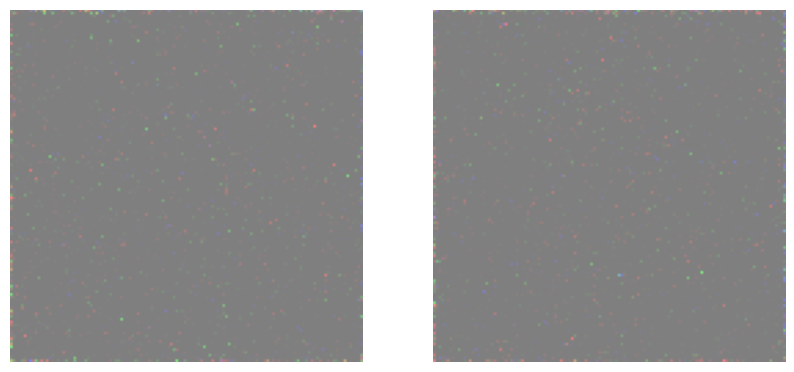

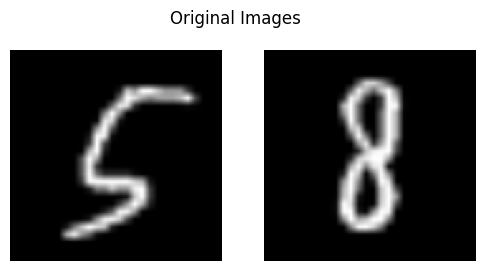

GIF saved at denoising_progression_image_1.gif
GIF saved at gaussian_noise_to_mnist_image_1.gif
GIF saved at denoising_progression_image_2.gif
GIF saved at gaussian_noise_to_mnist_image_2.gif


In [11]:
def main():
    data_loader = load_data()
    model, diffusion, optimizer = initialize_model()
    train(model, diffusion, optimizer, data_loader)

    generate_and_plot_images(diffusion)
    original_images = next(iter(data_loader))[0].to(DEVICE)
    show_images(original_images)

    # Create GIFs for each image in the batch
    for img_index in range(original_images.shape[0]):
        create_denoising_gif(original_images, diffusion, img_index)
        create_noise_interpolation_gif(original_images, img_index)


main()